**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
# import packages
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sympy as sm
from scipy import optimize
from scipy.optimize import minimize
import math

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2


## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $(1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [2]:
# define symbols
L = sm.symbols('L')
w = sm.symbols('w')
tau = sm.symbols('tau')
G = sm.symbols('G')
alpha = sm.symbols('alpha')
kappa = sm.symbols('kappa')
nu = sm.symbols('nu')
C = sm.symbols('C')


In [3]:
# define utility function using sympy
objective = sm.log((C**alpha)*G**(1-alpha))-nu*L**2/2

# budget constraint as an equality
constraint = sm.Eq(C,kappa+(1-tau)*w*L)

# insert budget constraint into objective function
objective_subs = objective.subs(C,constraint.rhs)

# take derivative of objective function with respect to L
foc = sm.diff(objective_subs,L)

# solve foc for L
L_star = sm.solve(sm.Eq(foc,0),L)[0]
L_star


(kappa*nu - sqrt(nu*(4*alpha*tau**2*w**2 - 8*alpha*tau*w**2 + 4*alpha*w**2 + kappa**2*nu)))/(2*nu*w*(tau - 1))

The above L_star is the solution to the workers labor supply problem. It differs a bit from the provided solution, but it appears that if you multiply with -1 in the denominator and numerator, and using $\tilde w$, then it should simplyfi to the provided solution. Below we show that the two solutions are the same for the given parameters. 

In [4]:
# our solution:
L_star_our = sm.lambdify(args = (w,tau,alpha,kappa,nu),expr = L_star)
L_star_our(1,0.3,0.5,1,1/(2*16**2))



15.30165022719559

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

In [5]:
# given solution:
L_star_sol = (-kappa+sm.sqrt(kappa**2+4*alpha/nu*((1-tau)*w)**2))/(2*(1-tau)*w)


# lambdify function for optimal labor supply
L_star_func = sm.lambdify(args = (w,tau,alpha,kappa,nu),expr = L_star_sol)
L_star_func(1,0.3,0.5,1,1/(2*16**2))





15.30165022719559

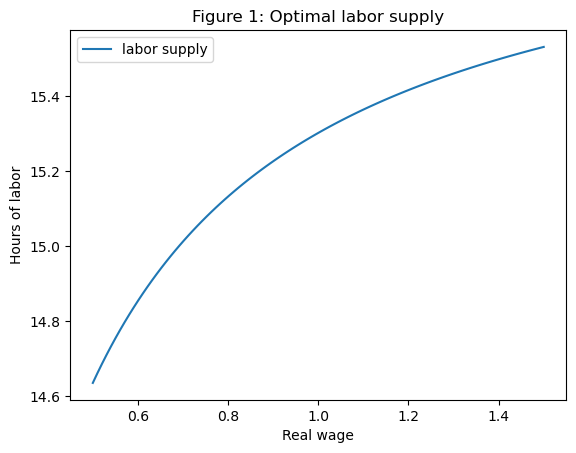

In [6]:
# define parameters
alpha = 0.5
kappa = 1.0
nu = 1/(2*16**2)
w = 1.0
tau = 0.3
G = np.array([1.0,2.0])

L_star_func(w,tau,alpha,kappa,nu)

# make linspace for w
w_vec = np.linspace(0.5,1.5,100)

# plot optimal labor supply for different values of w
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(w_vec,L_star_func(w_vec,tau,alpha,kappa,nu), label = "labor supply") 
ax.set_xlabel('Real wage')
ax.set_ylabel('Hours of labor')
ax.title.set_text('Figure 1: Optimal labor supply')
ax.legend()
plt.show()



Figure 1 illustrates how $L^*(\tilde w)$ depends on $w$. 

The labour supply is increasing when real wages are higher which corresponds to economic theory.


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


We first attempted to solve this problem using sympy and the sm.lambdify() function, where we encountered an error with the log. The workaround is seen below, where we instead define the utility function manually, with the optimal labor supply inserted. 

In [7]:
# define G function
def G_func(w,tau,alpha,kappa,nu):
    return tau*w*(-kappa+np.sqrt(kappa**2+4*alpha/nu*((1-tau)*w)**2))/(2*(1-tau)*w)*((1-tau)*w)

# lambdify G_func
G_func_lambda = lambda w,tau,alpha,kappa,nu: G_func(w,tau,alpha,kappa,nu)


# manual definition of utility function
def objective_v(w,tau,alpha,kappa,nu):
    return np.log(((kappa+(1-tau)*w*((-kappa+np.sqrt(kappa**2+4*alpha/nu*((1-tau)*w)**2))/(2*(1-tau)*w)))**alpha)*G_func(w,tau,alpha,kappa,nu)**(1-alpha))-nu*((-kappa+np.sqrt(kappa**2+4*alpha/nu*((1-tau)*w)**2))/(2*(1-tau)*w))**2/2

# lambdify objective_v
objective_lambda = lambda w,tau,alpha,kappa,nu: objective_v(w,tau,alpha,kappa,nu)





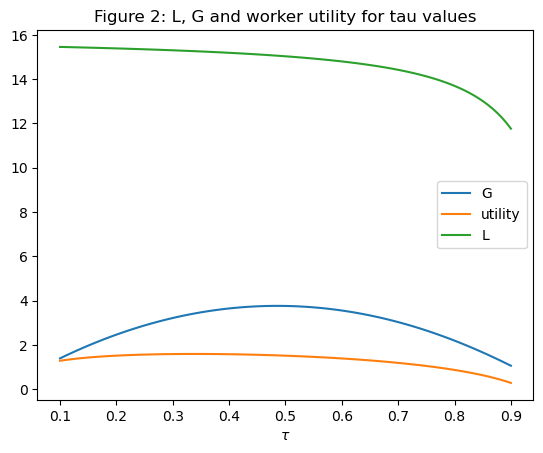

In [8]:
# plotting implied L, G and utility for a grid of tau values

# define tau grid
tau_vec = np.linspace(0.1,0.9,100)

# make 2d plot for G_func_lambda, objective_lambda and L_star_func
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(tau_vec,G_func_lambda(w,tau_vec,alpha,kappa,nu), label = "G")
ax.plot(tau_vec,objective_lambda(w,tau_vec,alpha,kappa,nu), label = "utility")
ax.plot(tau_vec,L_star_func(w,tau_vec,alpha,kappa,nu), label = "L")
ax.set_xlabel(r'$\tau$')
ax.set_title('Figure 2: L, G and worker utility for tau values')
ax.legend()
plt.show()

In figure 2, we see labor supply is decreasing in the tax rate. Worker utility appears to have a slight increase for low values of labor tax. Goverment consumption is initially increasing in the labor tax and then decreasing. The goverment consumption is parabolic. This is similar to the so-called "Laffer-curve". Goverment consumption appears maximized at around 50% labor tax.

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

tau_star = 0.338


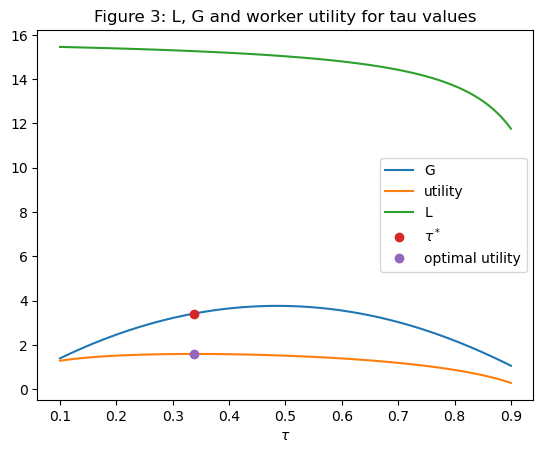

In [9]:
# maximize worker utility using scipy optimize.minimize

objective_lambda_min = lambda tau: -objective_lambda(w,tau,alpha,kappa,nu)
res = optimize.minimize_scalar(objective_lambda_min,method = 'bounded',bounds = (0,1))
tau_star = res.x
print(f'tau_star = {tau_star:.3f}')

# plot optimal tau
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(tau_vec,G_func_lambda(w,tau_vec,alpha,kappa,nu), label = "G")
ax.plot(tau_vec,objective_lambda(w,tau_vec,alpha,kappa,nu), label = "utility")
ax.plot(tau_vec,L_star_func(w,tau_vec,alpha,kappa,nu), label = "L")
ax.plot(tau_star,G_func_lambda(w,tau_star,alpha,kappa,nu),'o', label = r'$\tau^*$')
ax.plot(tau_star,objective_lambda(w,tau_star,alpha,kappa,nu),'o', label = "optimal utility")
ax.set_xlabel(r'$\tau$')
ax.set_title('Figure 3: L, G and worker utility for tau values')
ax.legend()
plt.show()



Figure 3 shows the optimal tax rate that maximizes worker utility. **$\tau^*$ shows the optimal tax rate, which is 0.338.** 

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma-1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [10]:
# solving worker problem for given values of G and tau using sympy

# reset sympy symbols for use in lambdify
L = sm.symbols('L')
w = sm.symbols('w')
tau = sm.symbols('tau')
G = sm.symbols('G')
alpha = sm.symbols('alpha')
kappa = sm.symbols('kappa')
nu = sm.symbols('nu')
C = sm.symbols('C')
sigma = sm.symbols('sigma')
rho = sm.symbols('rho')
epsilon = sm.symbols('epsilon')

# define ces utility function
objective_ces = (((alpha*C**((sigma-1)/sigma)+(1-alpha)*G**((sigma-1)/sigma))**(sigma/(sigma-1)))**(1-rho)-1)/(1-rho)-nu*L**(1+epsilon)/(1+epsilon)


# define budget constraint
budget_constraint_ces = sm.Eq(C,kappa+(1-tau)*w*L)


# insert budget constraint into utility function
objective_ces_bc = objective_ces.subs(C,budget_constraint_ces.rhs)

# take derivative of objective ces function with respect to L
objective_ces_bc_diff = sm.diff(objective_ces_bc,L)


# solve for L, throws an error. 
try:
    L_star_ces = sm.solve(sm.Eq(objective_ces_bc_diff,0),L)[0]
except:
    print('Error: No analytical solution found')



Error: No analytical solution found


**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [11]:
# write your code here  

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [12]:
# finding optimal labor numerically using scipy optimize.minimize

# define parameters
eta = 0.5
w = 1.0

# define profit function
def profit_func(l,kappa,eta,w):
    return kappa*l**(1-eta)-w*l

# lamdify objective function
objective = lambda l,kappa,eta,w: -profit_func(l,kappa,eta,w)

# optimize profit function for kappa = 1.0
res1 = optimize.minimize_scalar(objective,method = 'bounded',bounds = (0,100),args = (1.0,eta,w))

# optimize profit function for kappa = 2.0
res2 = optimize.minimize_scalar(objective,method = 'bounded',bounds = (0,100),args = (2.0,eta,w))

print(f'labor when kappa = 1: {res1.x:.3f} and labor when kappa = 2: {res2.x:.3f}')

# profits are then:
print(f'profits when kappa = 1: {profit_func(res1.x,1.0,eta,w):.3f} and profits when kappa = 2: {profit_func(res2.x,2.0,eta,w):.3f}')

labor when kappa = 1: 0.250 and labor when kappa = 2: 1.000
profits when kappa = 1: 0.250 and profits when kappa = 2: 1.000


**Optimal labor is then 0.25 and 1 for $\kappa$ = 1 and 2, respectively.** The analytical solution gives the same answer: for kappa = 1: $\ell_{t}=\left(\frac{(1-\frac{1}{2})*1}{1}\right)^{\frac{1}{\frac{1}{2}}}=0.25$. And when kappa = 2: $\ell_{t}=\left(\frac{(1-\frac{1}{2})*2}{1}\right)^{\frac{1}{\frac{1}{2}}}=1$.

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K-1} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [13]:
# Approach one - does not succeed

# define parameters
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1+0.01)**(1/12)
eta = 0.5
w = 1.0

# define kappa shock function
def kappa_shock_func(kappa,rho,sigma_epsilon):
    return rho*kappa+np.random.normal(-0.5*sigma_epsilon**2,sigma_epsilon)

# define kappa function
def kappa_func(kappa,rho,sigma_epsilon):
    kappa_shock = kappa_shock_func(kappa,rho,sigma_epsilon)
    return np.exp(kappa_shock)

# define labor function
def labor_func(kappa,eta,w):
    return ((1-eta)*kappa/w)**(1/eta)

# calculate ex post value function
def ex_post_func(kappa, eta, w, iota, R):
    # initialize kappa and labor
    kappa_list = [kappa]
    labor_list = [labor_func(kappa, eta, w)]
    # loop over 119 periods
    for i in range(1, 120):
        # update kappa and labor
        kappa = kappa_func(kappa, rho, sigma_epsilon)
        kappa_list.append(kappa)
        labor_list.append(labor_func(kappa, eta, w))
    # calculate profits
    profit_list = [profit_func(l, kappa_list[i], eta, w) for i, l in enumerate(labor_list)]
    # calculate adjustment costs
    adjustment_cost_list = [iota if labor_list[i] != labor_list[i - 1] else 0 for i in range(1, 120)]
    # calculate ex post value
    ex_post_value = sum([R ** (-t) * (profit_list[t] - adjustment_cost_list[t]) for t in range(120)])
    return ex_post_value

# calculate ex ante value
K = 1000
try:
    ex_ante_value = sum([ex_post_func(1.0, eta, w, iota, R) for _ in range(K-1)]) / K
    print(f'ex ante value: {ex_ante_value}')
except:
    print('Error')

Error


/var/folders/83/24dlg4vd1vbghx31ntgf04sc0000gn/T/ipykernel_18417/4245285596.py:18: RuntimeWarning: overflow encountered in exp
  return np.exp(kappa_shock)
/var/folders/83/24dlg4vd1vbghx31ntgf04sc0000gn/T/ipykernel_18417/2521730447.py:9: RuntimeWarning: invalid value encountered in scalar subtract
  return kappa*l**(1-eta)-w*l


In [14]:
from q2 import H # import solution, which is the second approach - this one succeeds

In [43]:
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1+0.01)**(1/12)
eta = 0.5
w = 1.0

H(rho, iota, sigma_epsilon, R, eta, w, K)

Discounted sum of profit: 27.714


Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [41]:
# Parameters
delta = 0.05  # Threshold value for policy change
# set seed
np.random.seed(1986)

# Function to calculate profit at each time period
def calculate_profit(ell_t, kappa_t, ell_previous, w, iota):
    adjustment_cost = iota if ell_t != ell_previous else 0
    profit = kappa_t*ell_t**(1-eta) - w * ell_t - adjustment_cost
    return profit

# Function to calculate ex post value of the salon for a given shock series and policy
def calculate_ex_post_value(shock_series, delta):
    ex_post_value = 0
    ell_previous = 0
    kappa_previous = 1

    for t in range(len(shock_series)):
        kappa_t = np.exp(rho * np.log(kappa_previous) + shock_series[t])

        ell_star = ((1 - eta) * kappa_t / w)**(1 / eta)

        if abs(ell_previous - ell_star) > delta:
            ell_t = ell_star
        else:
            ell_t = ell_previous

        profit = calculate_profit(ell_t, kappa_t, ell_previous, w, iota)
        ex_post_value += R ** (-t) * profit

        ell_previous = ell_t

    return ex_post_value

# Generate K random shock series
shock_series = np.random.normal(loc=-0.5 * sigma_epsilon**2, scale=sigma_epsilon, size=(K-1, 120))

# Calculate ex post value for each shock series with Delta = 0
ex_post_values_delta_0 = [calculate_ex_post_value(shock, delta=0) for shock in shock_series]

# Calculate ex ante expected value H with Delta = 0
H_delta_0 = np.mean(ex_post_values_delta_0)

# Calculate ex post value for each shock series with Delta = 0.05
ex_post_values_delta_0_05 = [calculate_ex_post_value(shock, delta) for shock in shock_series]

# Calculate ex ante expected value H with Delta = 0.05
H_delta_0_05 = np.mean(ex_post_values_delta_0_05)

print(f"Approximated ex ante expected value H (Delta = 0): {H_delta_0:.3f}")
print(f"Approximated ex ante expected value H (Delta = 0.05): {H_delta_0_05:.3f}")

# Compare profitability
if H_delta_0_05 > H_delta_0:
    print("The policy with Delta = 0.05 improves profitability.")
elif H_delta_0_05 < H_delta_0:
    print("The policy with Delta = 0.05 does not improve profitability.")
else:
    print("The policy with Delta = 0.05 has the same profitability as the policy with Delta = 0.")

Approximated ex ante expected value H (Delta = 0): 27.714
Approximated ex ante expected value H (Delta = 0.05): 28.261
The policy with Delta = 0.05 improves profitability.


Changing $\Delta$ to 0.05 does indeed improve profitability. This appears to be the case, since with no threshold value for policy change, then the amount of hairdressers will change too much when you include a fixed cost for changing labor amounts. 

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

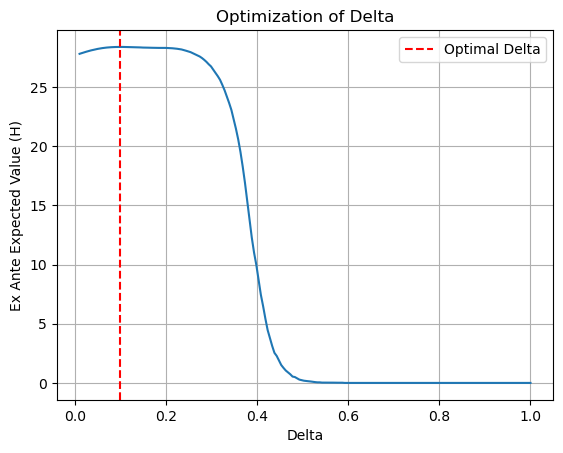

Optimal Delta: 0.09955
Maximum Ex Ante Expected Value (H): 28.40344


In [37]:
# set seed
np.random.seed(1986)
# Parameters
delta_values = np.linspace(0.01, 1, 200)  # Range of delta values to test

# Function to calculate profit at each time period
def calculate_profit(ell_t, kappa_t, ell_previous, w, iota):
    adjustment_cost = iota if ell_t != ell_previous else 0
    profit = kappa_t*ell_t**(1-eta) - w * ell_t - adjustment_cost
    return profit

# Function to calculate ex post value of the salon for a given shock series and policy
def calculate_ex_post_value(shock_series, delta):
    ex_post_value = 0
    ell_previous = 0
    kappa_previous = 1

    for t in range(len(shock_series)):
        kappa_t = np.exp(rho * np.log(kappa_previous) + shock_series[t])

        ell_star = ((1 - eta) * kappa_t / w)**(1 / eta)

        if abs(ell_previous - ell_star) > delta:
            ell_t = ell_star
        else:
            ell_t = ell_previous

        profit = calculate_profit(ell_t, kappa_t, ell_previous, w, iota)
        ex_post_value += R ** (-t) * profit

        ell_previous = ell_t

    return ex_post_value

# Generate K random shock series
shock_series = np.random.normal(loc=-0.5 * sigma_epsilon**2, scale=sigma_epsilon, size=(K-1, 120))

# Calculate ex ante expected value H for different Delta values
ex_ante_values = []
for delta in delta_values:
    ex_post_values = [calculate_ex_post_value(shock, delta) for shock in shock_series]
    ex_ante_value = np.mean(ex_post_values)
    ex_ante_values.append(ex_ante_value)

# Find optimal Delta maximizing H
optimal_delta = delta_values[np.argmax(ex_ante_values)]
max_ex_ante_value = np.max(ex_ante_values)

# Plotting the results
plt.plot(delta_values, ex_ante_values)
plt.xlabel("Delta")
plt.ylabel("Ex Ante Expected Value (H)")
plt.title("Optimization of Delta")
plt.axvline(x=optimal_delta, color='r', linestyle='--', label='Optimal Delta')
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal Delta: {optimal_delta:.5f}")
print(f"Maximum Ex Ante Expected Value (H): {max_ex_ante_value:.5f}")


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [18]:
# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [19]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [20]:
from q3 import algorithm

# Define parameters
bounds = [-600, 600]
tol = 1e-8
K_underline = 10
K = 1000

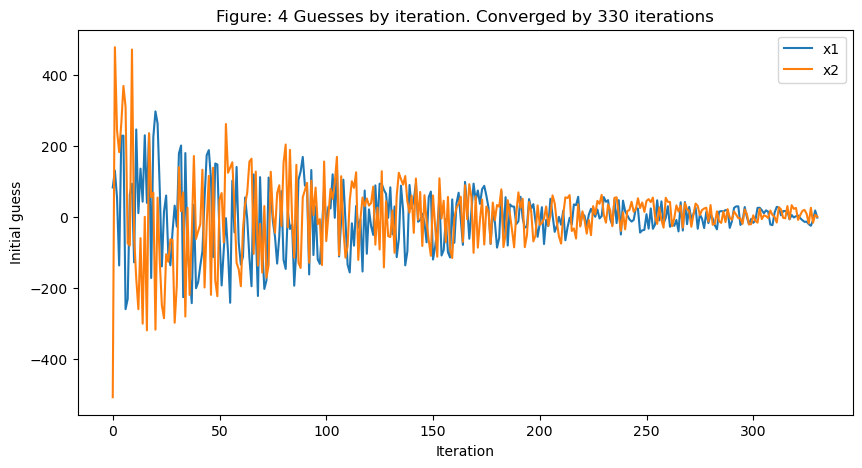

The optimal x is [-1.08340235e-08 -2.19334849e-08]


In [21]:
algorithm(K_underline, K, bounds, tol, figure_number=4)

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

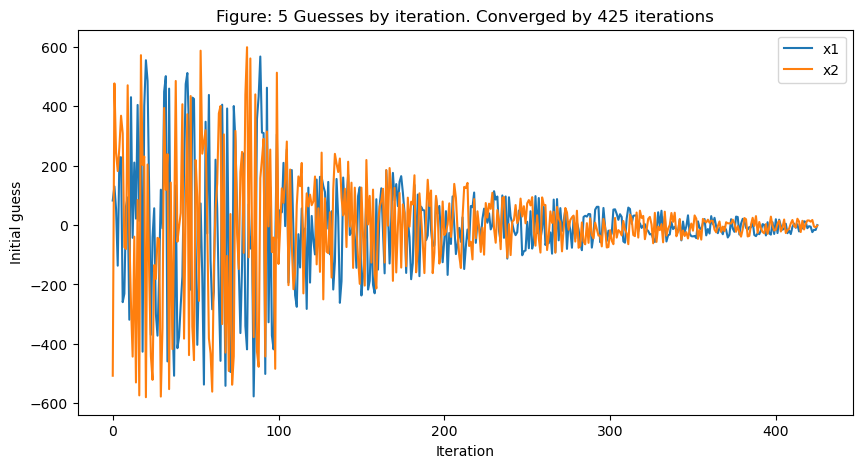

The optimal x is [ 6.1505135e-09 -1.2704616e-08]


In [22]:
algorithm(100, K, bounds, tol, figure_number=5)

It appears that using fever warm ups leads to faster convergens. But with a function like the griewank, one could be worried about the many local minima will cause the minimizer to get stuck early. 